# Braille Classifier

In [1]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

In [2]:
os.mkdir('./images/')
alpha = 'a'
for i in range(0, 26): 
    os.mkdir('./images/' + alpha)
    alpha = chr(ord(alpha) + 1)

rootdir = '/kaggle/input/braille-character-dataset/Braille Dataset/Braille Dataset/'
for file in os.listdir(rootdir):
    letter = file[0]
    copyfile(rootdir+file, './images/' + letter + '/' + file)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')

Using TensorFlow backend.


Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [4]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Epoch 1/666
39/39 [==============================] - 2s 57ms/step - loss: 3.2874 - accuracy: 0.0385 - val_loss: 3.2778 - val_accuracy: 0.0321
Epoch 2/666
39/39 [==============================] - 2s 44ms/step - loss: 3.1379 - accuracy: 0.0946 - val_loss: 2.8176 - val_accuracy: 0.1474
Epoch 3/666
39/39 [==============================] - 2s 45ms/step - loss: 2.7154 - accuracy: 0.1923 - val_loss: 2.3433 - val_accuracy: 0.2885
Epoch 4/666
39/39 [==============================] - 2s 46ms/step - loss: 2.3037 - accuracy: 0.3133 - val_loss: 1.9517 - val_accuracy: 0.4006
Epoch 5/666
39/39 [==============================] - 2s 50ms/step - loss: 1.9542 - accuracy: 0.4423 - val_loss: 1.9445 - val_accuracy: 0.4455
Epoch 6/666
39/39 [==============================] - 2s 45ms/step - loss: 1.6475 - accuracy: 0.5248 - val_loss: 1.3256 - val_accuracy: 0.5513
Epoch 7/666
39/39 [==============================] - 2s 46ms/step - loss: 1.3303 - accuracy: 0.6138 - val_loss: 0.9939 - val_accuracy: 0.5224
Epoch 

In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 26, 26, 64)        283       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 11, 11, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 4, 4, 256)         33536     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)               0   

In [6]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

model accuracy: 0.9135


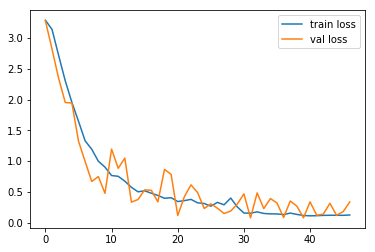

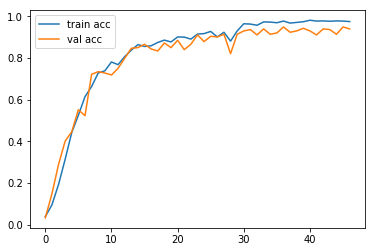

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
pred = model.predict(val_generator)
pred

array([[4.7982883e-04, 9.9891257e-01, 2.2676026e-05, ..., 2.9297472e-15,
        1.2159501e-22, 2.1791890e-15],
       [1.3157390e-06, 9.9910384e-01, 3.2224700e-05, ..., 2.2147057e-24,
        2.3095888e-32, 2.2317676e-18],
       [2.1670423e-13, 1.2733711e-15, 6.1157036e-13, ..., 1.1408425e-10,
        3.4505421e-09, 7.4302280e-01],
       ...,
       [5.7642430e-04, 2.8982301e-08, 1.6344032e-04, ..., 8.6076972e-11,
        3.0039703e-17, 4.0238839e-09],
       [7.3478716e-09, 3.3912983e-14, 3.8439812e-10, ..., 3.0756341e-06,
        5.1551445e-12, 2.1121812e-03],
       [5.4883645e-03, 1.0232915e-03, 7.9360016e-02, ..., 2.1101062e-03,
        2.5700984e-04, 5.6760993e-02]], dtype=float32)

In [9]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/kaggle/input/braille-character-dataset/Braille Dataset/Braille Dataset/a1.JPG0dim.jpg')

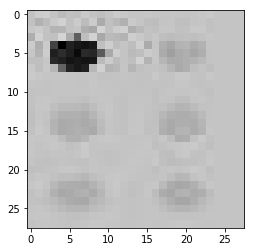

In [10]:
plt.imshow(img)

In [11]:
x=image.img_to_array(img)
x

array([[[194., 194., 194.],
        [204., 204., 204.],
        [206., 206., 206.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[193., 193., 193.],
        [177., 177., 177.],
        [188., 188., 188.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[199., 199., 199.],
        [203., 203., 203.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       ...,

       [[196., 196., 196.],
        [197., 197., 197.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[197., 197., 197.],
        [198., 198., 198.],
        [198., 198., 198.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[194., 194., 194.],
        [196., 196., 196.],
        [197., 1

In [12]:
x.shape

(28, 28, 3)

In [13]:
x=np.expand_dims(x,axis=0)
model.predict(x)

array([[9.7944242e-01, 4.6658562e-03, 5.7882904e-03, 9.3069154e-08,
        5.6737017e-06, 7.5449054e-07, 5.0000953e-10, 1.1227711e-08,
        7.1223134e-05, 8.3875649e-11, 9.4290012e-03, 1.9990798e-08,
        2.0487585e-09, 8.0050819e-09, 3.0875472e-07, 8.6961421e-07,
        2.4091770e-11, 3.0740864e-08, 5.6787196e-04, 2.4450608e-13,
        2.7607106e-05, 4.8362741e-11, 2.9950623e-15, 1.8122639e-08,
        1.0624439e-13, 1.0066888e-09]], dtype=float32)

In [14]:
a=np.argmax(model.predict(x), axis=1)
a

array([0])